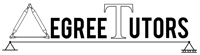
<center>www.DegreeTutors.com</center>

# 2D Cable Net and Catenary Structures

## Import dependencies

In [1]:
# DEPENDENCIES
import copy #Allows us to create copies of objects in memory
import math #Math functionality
import numpy as np #Numpy for working with arrays
import matplotlib.pyplot as plt #Plotting functionality 
import matplotlib.colors #For colormap functionality
import ipywidgets as widgets
from glob import glob #Allows check that file exists before import
from numpy import genfromtxt #For importing structure data from csv

## Automatic structure & loading data import

In [2]:
#=================================START OF DATA IMPORT================================
#MANDATORY IMPORT: nodal coordinates
if glob('data/Vertices.csv'): 
    nodes = genfromtxt('data/Vertices.csv', delimiter=',') 
    print('1. 🟢 Vertices.csv imported')
else: 
    print('1. 🛑 STOP: Vertices.csv not found')
    
#MANDATORY IMPORT: member definitions
if glob('data/Edges.csv'): 
    members = genfromtxt('data/Edges.csv', delimiter=',')
    members = np.int_(members) 
    nDoF = np.amax(members)*2 #Total number of degrees of freedom in the problem
    print('2. 🟢 Edges.csv imported')
else: 
    print('2. 🛑 STOP: Edges.csv not found')

#MANDATORY IMPORT: restraint definitions
if glob('data/Restraint-Data.csv'): 
    restraintData = genfromtxt('data/Restraint-Data.csv', delimiter=',')  
    restraintData = np.int_(restraintData) #Convert members definitions from float to int
    flatData = restraintData.flatten() #Flatten DoF data
    restrainedDoF = flatData[np.nonzero(flatData)[0]].tolist() #Remove zeros from DoF data
    restrainedIndex = [x - 1 for x in restrainedDoF] #Generate index values for each DoF
    freeDoF = np.delete( np.arange(0,nDoF),restrainedIndex) #Generate array of unrestrained DoF
    print('3. 🟢 Restraint-Data.csv imported')
    print('restrainedDoF', restrainedDoF)
else:
    print('3. 🛑 STOP: Restraint-Data.csv not found')
    
#OPTIONAL IMPORT: force location data
if glob('data/Force-Data.csv'): 
    forceLocationData = genfromtxt('data/Force-Data.csv', delimiter=',')
    forceLocationData = np.int_(forceLocationData) #Convert from float to int
    nForces = len(np.array(forceLocationData.shape))
    if nForces<2:
        forceLocationData = np.array([forceLocationData]) 
    print('4. 🟢 Force-Data.csv imported')              
else:
    forceLocationData = []
    print('4. ⚠️ Force-Data.csv not found')
    

1. 🟢 Vertices.csv imported
2. 🟢 Edges.csv imported
3. 🟢 Restraint-Data.csv imported
restrainedDoF [1, 2, 13, 14]
4. 🟢 Force-Data.csv imported


## Manual data entry

In [3]:
# #Constants - CASE A: 3-bar catenary
# E = 70*10**9 #(N/m^2)
# A = 0.0000025 #(m^2) 0.0025

# gamma = 0 #(kg/m) Cable mass per unit length
# swt = False #Self-weight into account flag
# Areas = A*np.ones([len(members)]) #An array to hold individual area for each member 
# P0 = 0*np.ones([len(members)]) #An array to hold individual member pre-tension values
# P = -10000 #(N) Point load magnitude (and direction via sign)
# pointLoadAxis = 'y' #The GLOBAL axis along which point loads are applied

# nForceIncrements = 1000 #Number of force increments
# convThreshold = 30 #(N) Threshold on maximum value of F_inequilibrium

In [4]:
#Constants - CASE B: 6-bar catenary, loads on nodes 2 and 3
E = 70*10**9 #(N/m^2)
A = 0.0025 #(m^2)

gamma = .1 #(kg/m) Cable mass per unit length
swt = True #Take self-weight into account 
Areas = A*np.ones([len(members)]) #An array to hold individual area for each member 
P0 = 1000*np.ones([len(members)]) #An array to hold individual member pre-tension values
P = -10000 #(N) Point load magnitude (and direction via sign)
pointLoadAxis = 'y' #The GLOBAL axis along which point loads are applied

nForceIncrements = 1500
convThreshold = 100 #(N) Threshold on average percentage increase in incremental deflection

## Add point loads to global force vector

In [5]:
forceVector = np.array([np.zeros(len(nodes)*2)]).T
if(len(forceLocationData)>0):     
    #Split force location data (index starting at 0)
    forcedNodes = forceLocationData[:,0]
    xForceIndices = forceLocationData[:,1]
    yForceIndices = forceLocationData[:,2]

    #Assign forces to degrees of freedom
    if(pointLoadAxis=='x'):
        forceVector[xForceIndices] = P
    elif(pointLoadAxis=='y'):
        forceVector[yForceIndices] = P
        
forceVector

array([[     0.],
       [     0.],
       [     0.],
       [-10000.],
       [     0.],
       [-10000.],
       [     0.],
       [     0.],
       [     0.],
       [-10000.],
       [     0.],
       [-10000.],
       [     0.],
       [     0.]])

In [6]:
# forceVector[3] = 0
# forceVector[11] = 0
# print(forceVector)

## Calculate initial length for each member based on initial position (L0)

In [7]:
lengths = np.zeros(len(members))
for n, mbr in enumerate(members):
    
    #Calculate undeformed length of member
    node_i = mbr[0] #Node number for node i of this member
    node_j = mbr[1] #Node number for node j of this member
    ix = nodes[node_i-1][0] #x-coord for node i 
    iy = nodes[node_i-1][1] #y-coord for node i
    jx = nodes[node_j-1][0] #x-coord for node j
    jy = nodes[node_j-1][1] #y-coord for node j

    dx = jx-ix #x-component of vector along member
    dy = jy-iy #y-component of vector along member
    length = math.sqrt(dx**2 + dy**2) #Magnitude of vector (length of member)
    lengths[n] = length  
    
(members, lengths)

(array([[1, 2],
        [3, 4],
        [2, 3],
        [4, 5],
        [5, 6],
        [6, 7]]),
 array([0.70710678, 0.5       , 0.70710678, 0.5       , 0.70710678,
        0.70710678]))

## Calculate and add self-weight to force vector

In [8]:
if(swt):
    SW_at_supports = np.empty((0,2))
    for n, mbr in enumerate(members):  
        node_i = mbr[0] #Node number for node i of this member
        node_j = mbr[1] #Node number for node j of this member
        length = lengths[n]     
        sw = length*gamma*9.81 #(N) Self-weight of the member
        F_node = sw/2 #(N) Self-weight distributed into each node  
        iy = 2*node_i-1 #index of y-DoF for node i
        jy = 2*node_j-1 #index of y-DoF for node j         
        forceVector[iy] = forceVector[iy]-F_node
        forceVector[jy] = forceVector[jy]-F_node  
        
        #Check if SW needs to be directly added to supports (if elements connect to supports)
        if(iy+1 in restrainedDoF):
            supportSW = np.array([iy, F_node])
            SW_at_supports = np.append(SW_at_supports, [supportSW], axis=0) #Store y-DoF at support and force to be added
        if(jy+1 in restrainedDoF):
            supportSW = np.array([jy, F_node])
            SW_at_supports = np.append(SW_at_supports, [supportSW], axis=0) #Store y-DoF at support and force to be added                    
            
    print(forceVector)
    print(SW_at_supports)

[[ 0.00000000e+00]
 [-3.46835876e-01]
 [ 0.00000000e+00]
 [-1.00006937e+04]
 [ 0.00000000e+00]
 [-1.00005921e+04]
 [ 0.00000000e+00]
 [-4.90500000e-01]
 [ 0.00000000e+00]
 [-1.00005921e+04]
 [ 0.00000000e+00]
 [-1.00006937e+04]
 [ 0.00000000e+00]
 [-3.46835876e-01]]
[[ 1.          0.34683588]
 [13.          0.34683588]]


## Plot structure to confirm before proceeding

In [ ]:
def plotStructure(label_offset=0.02, xMargin=0.2, yMargin=0.4, scaleFactor=1, arrowScale=0.05, arrowWidth=0.01): 
    fig = plt.figure() 
    axes = fig.add_axes([0.1,0.1,3,3]) 
    fig.gca().set_aspect('equal', adjustable='box')   
    
    #Plot markers indicating support restraints---------------------------------------
    for n, Node in enumerate(nodes):       
        node=n+1 #Node number                
        i_hor = 2*node-2 #horizontal DoF at this node
        i_ver = 2*node-1 #vertical DoF at this node                           
        ix = nodes[node-1,0] #x-coord of this node
        iy = nodes[node-1,1] #y-coord of this node
        
        if abs(forceVector[i_hor])>0:
            #Horizontal force applied at this node
            arrowLength = forceVector[i_hor]/max(abs(forceVector))[0] * arrowScale
            plt.arrow(ix, iy, arrowLength[0], 0, width=arrowWidth, facecolor='#33cc99', edgecolor="black")            
            plt.annotate(str(round(forceVector[i_hor][0]/1000,2))+' kN', xy = (ix+arrowLength[0]+label_offset, iy+label_offset),weight='bold') 
        if abs(forceVector[i_ver])>0:
            #Vertical force applied at this node
            arrowLength = forceVector[i_ver]/max(abs(forceVector))[0]  * arrowScale
            plt.arrow(ix, iy, 0, arrowLength[0], width=arrowWidth, facecolor='#33cc99', edgecolor="black")
            plt.annotate(str(round(forceVector[i_ver][0]/1000,2))+' kN', xy = (ix+label_offset, iy+arrowLength[0]+label_offset),weight='bold') 
        
                
        if i_hor in restrainedIndex and i_ver in restrainedIndex:
            axes.plot([ix],[iy],'+',
                  markeredgecolor='black',
                  markersize=50,
                  markeredgewidth=3) 
        elif i_hor in restrainedIndex:
            axes.plot([ix],[iy],'_',
                  markeredgecolor='black',
                  markersize=50,
                  markeredgewidth=3) 
        elif i_ver in restrainedIndex:
            axes.plot([ix],[iy],'|',
                  markeredgecolor='black',
                  markersize=50,
                  markeredgewidth=3) 
            
    #Plot members------------------------------------------------------------------------
    for mbr in members:  
        node_i = mbr[0] #Node number for node i of this member
        node_j = mbr[1] #Node number for node j of this member                

        ix = nodes[node_i-1,0] #x-coord of node i of this member
        iy = nodes[node_i-1,1] #y-coord of node i of this member
        jx = nodes[node_j-1,0] #x-coord of node j of this member
        jy = nodes[node_j-1,1] #y-coord of node j of this member        

        #Index of DoF for this member
        ia = 2*node_i-2 #horizontal DoF at node i of this member 
        ib = 2*node_i-1 #vertical DoF at node i of this member
        ja = 2*node_j-2 #horizontal DoF at node j of this member
        jb = 2*node_j-1 #vertical DoF at node j of this member

        axes.plot([ix,jx],[iy,jy],color='#33cc99',linestyle='-',lw=2) #Member

        
    #Plot nodes--------------------------------------------------------------------------
    for n, node in enumerate(nodes):
        axes.plot([node[0]],[node[1]],'o',
                  markerfacecolor='white', 
                  markeredgecolor='black') 
        label = str(n+1) #The node number label string
        axes.text(node[0]+label_offset, node[1]+label_offset, label, fontsize=16) #Add node label

        
    #Housekeeping - set axis limits to provide margin around structure-------------------
    maxX = nodes.max(0)[0]
    maxY = nodes.max(0)[1]
    minX = nodes.min(0)[0]
    minY = nodes.min(0)[1]
    axes.set_xlim([minX-xMargin,maxX+xMargin])
    axes.set_ylim([minY-yMargin,maxY+yMargin])
    
    axes.set_xlabel('Distance (m)', fontsize=16)
    axes.set_ylabel('Distance (m)', fontsize=16)
    axes.set_title('Structure to analyse (initial position)', fontsize=16, weight='bold')
    axes.grid()
    

#Call the interact widget----------------------------------------------------------------   
widgets.interact(plotStructure, 
                 label_offset=(0.01, 0.1, 0.01), 
                 xMargin=(0.2, 1, 0.1),
                 yMargin=(0.2, 1, 0.1),
                 scaleFactor=(1,5,0.5), 
                 arrowScale=(0.1,1,0.1), 
                 arrowWidth=(0.01,0.05,0.01)) 
plt.show()

interactive(children=(FloatSlider(value=0.02, description='label_offset', max=0.1, min=0.01, step=0.01), Float…

<hr>

# Functions

## Function: Calculate single member transformation matrix based on nodal coordinates

In [10]:
def calculateTransMatrix(posI, posJ):
    """
    Takes in the position of node I and J and returns the transformation matrix for the member
    This will to be recalculated as the structure deflects with each iteration
    """    
    T = np.zeros([2,4])
    ix = posI[0] #x-coord for node i 
    iy = posI[1] #y-coord for node i
    jx = posJ[0] #x-coord for node j
    jy = posJ[1] #y-coord for node j  

    dx = jx-ix #x-component of vector along member
    dy = jy-iy #y-component of vector along member
    length = math.sqrt(dx**2 + dy**2) #Magnitude of vector (length of member)
    
    lp = dx/length
    mp = dy/length
    lq = -mp
    mq = lp
    
    T = np.array([[-lp, -mp, lp, mp],[-lq, -mq, lq, mq]])

    return T

## Function: Calculate all transformation matrices based on deformed shape of structure

In [11]:
def calculateTransMatrices(UG):
    """
    Calculate transformation matrices for each member based on current deformed shape for the structure
    Current deformed shape is initial position plus cumulative displacements passed in as UG
    """
    #Initialise container to hold transformation matrices
    TransformationMatrices = np.zeros((len(members), 2, 4))
    
    for n, mbr in enumerate(members): 
        node_i = mbr[0] #Node number for node i of this member
        node_j = mbr[1] #Node number for node j of this member
        
        #Index of DoF for this member
        ia = 2*node_i-2 #horizontal DoF at node i of this member 
        ib = 2*node_i-1 #vertical DoF at node i of this member
        ja = 2*node_j-2 #horizontal DoF at node j of this member
        jb = 2*node_j-1 #vertical DoF at node j of this member   

        #New positions = initial pos + cum deflection
        ix = nodes[node_i-1,0] + UG[ia,0]
        iy = nodes[node_i-1,1] + UG[ib,0] 
        jx = nodes[node_j-1,0] + UG[ja,0]
        jy = nodes[node_j-1,1] + UG[jb,0]

        #Recalculate transformation matrix [T] using updated nodal positions
        TM = calculateTransMatrix([ix, iy], [jx, jy])
         
        #Store transformation matrix for current member
        TransformationMatrices[n,:,:] = TM
    
    return TransformationMatrices   

## Function: Calculate pre-tension force vector for the system

In [12]:
def initPretension():
    """
    P = axial pre-tension specified for each bar
    Calculate the force vector [F_pre] for each bar [F_pre] = [T'][AA'][P]
    Combine into an overal vector representing the internal force system and return    
    """
    F_pre = np.array([np.zeros(len(forceVector))]).T #Initialse internal force vector
        
    for n, mbr in enumerate(members):         
        node_i = mbr[0] #Node number for node i of this member
        node_j = mbr[1] #Node number for node j of this member
        
        #Index of DoF for this member
        ia = 2*node_i-2 #horizontal DoF at node i of this member 
        ib = 2*node_i-1 #vertical DoF at node i of this member
        ja = 2*node_j-2 #horizontal DoF at node j of this member
        jb = 2*node_j-1 #vertical DoF at node j of this member 
        
        #Determine internal pre-tension in global coords
        TM = TMs[n,:,:]        
        AAp = np.array([[1],[0]])
        P = P0[n]        
        F_pre_global = np.matmul(TM.T,AAp)*P                         
          
        #Add member pre-tension to overall record
        F_pre[ia,0] = F_pre[ia,0] + F_pre_global[0][0]
        F_pre[ib,0] = F_pre[ib,0] + F_pre_global[1][0]
        F_pre[ja,0] = F_pre[ja,0] + F_pre_global[2][0]
        F_pre[jb,0] = F_pre[jb,0] + F_pre_global[3][0]

    return F_pre

## Function:  Build the local stiffness matrix for each member

In [13]:
def buildElementStiffnessMatrix(n, UG):
    """
    Build element stiffness matrix based on current position and axial force
    n = member index
    UG = vector of global cumulative displacements
    """
    
    #Calculate 'new' positions of nodes using UG
    node_i = members[n][0] #Node number for node i of this member
    node_j = members[n][1] #Node number for node j of this member 

    #Index of DoF for this member
    ia = 2*node_i-2 #horizontal DoF at node i of this member 
    ib = 2*node_i-1 #vertical DoF at node i of this member
    ja = 2*node_j-2 #horizontal DoF at node j of this member
    jb = 2*node_j-1 #vertical DoF at node j of this member 
    
    #Displacements
    d_ix = UG[ia,0]
    d_iy = UG[ib,0]
    d_jx = UG[ja,0]
    d_jy = UG[jb,0]
              
    #Extract current version of transformation matrix [T] 
    TM = TMs[n,:,:]        
                
    #Calculate local displacements [u, v, w] using global cumulative displacements UG
    localDisp = np.matmul(TM,np.array([[d_ix, d_iy, d_jx, d_jy]]).T)
    u = localDisp[0].item()
    v = localDisp[1].item()
    
    #Calculate extension, e
    Lo = lengths[n]
    e = math.sqrt((Lo+u)**2 + v**2)-Lo
        
    #Calculate matrix [AA]
    a1 = (Lo+u)/(Lo+e)
    a2 = v/(Lo+e)
    AA = np.array([[a1,a2]])
    
    #Calculate axial load, P        
    P = P0[n] + (E*Areas[n]/Lo)*e
    
    #Calculate matrix [d]
    d11 = P*v**2
    d12 = -P*v*(Lo+u)
    d21 = -P*v*(Lo+u)
    d22 = P*(Lo+u)**2
    denominator = (Lo+e)**3
    
    d = (1/denominator)*np.array([[d11,d12],
                                  [d21,d22]])  
    
    #Calculate element stiffness matrix
    NL = np.matrix((AA.T*(E*Areas[n]/Lo)*AA)+d)
    k = TM.T*NL*TM      
    
    #Return element stiffness matrix in quadrants 
    K11 = k[0:2,0:2]
    K12 = k[0:2,2:4]
    K21 = k[2:4,0:2]
    K22 = k[2:4,2:4]
        
    return [K11, K12, K21, K22]  

In [14]:
# #Testing one stiffness matrix
# # Suppose there are 3 nodes → 6 DoFs (0 to 5)
# UG = np.zeros([nDoF,1])

# # Call function on member 0
# TMs = calculateTransMatrices(UG)
# k_quadrants = buildElementStiffnessMatrix(0, UG)

# # Display the quadrants
# K11, K12, K21, K22 = k_quadrants
# print("K11:\n", K11)
# print("K12:\n", K12)
# print("K21:\n", K21)
# print("K22:\n", K22)

## Function: Build structure stiffness matrix [Kn]

In [15]:
def buildStructureStiffnessMatrix(UG):
    """
    Standard construction of Primary and Structure stiffness matrix
    Construction of non-linear element stiffness matrix handled in a child function
    """    
    Kp = np.zeros([nDoF,nDoF]) #Initialise the primary stiffness matrix
    
    for n, mbr in enumerate(members): 
        node_i = mbr[0] #Node number for node i of this member
        node_j = mbr[1] #Node number for node j of this member
        
        #Construct (potentially) non-linear element stiffness matrix
        [K11, K12, K21,K22] = buildElementStiffnessMatrix(n, UG)            

        #Primary stiffness matrix indices associated with each node
        #i.e. node 1 occupies indices 0 and 1 (accessed in Python with [0:2])
        ia = 2*node_i-2 #index 0
        ib = 2*node_i-1 #index 1
        ja = 2*node_j-2 #index 2
        jb = 2*node_j-1 #index 3
        Kp[ia:ib+1,ia:ib+1] = Kp[ia:ib+1,ia:ib+1] + K11
        Kp[ia:ib+1,ja:jb+1] = Kp[ia:ib+1,ja:jb+1] + K12
        Kp[ja:jb+1,ia:ib+1] = Kp[ja:jb+1,ia:ib+1] + K21
        Kp[ja:jb+1,ja:jb+1] = Kp[ja:jb+1,ja:jb+1] + K22
         
    #Reduce to structure stiffness matrix by deleting rows and columns for restrained DoF
    Ks = np.delete(Kp,restrainedIndex,0) #Delete rows
    Ks = np.delete(Ks,restrainedIndex,1) #Delete columns
    Ks = np.matrix(Ks) # Convert Ks from numpy.ndarray to numpy.matrix to use build in inverter function
        
    return Ks

In [16]:
# # Test code by Thomas
# UG = np.zeros([nDoF,1])
# TMs = calculateTransMatrices(UG)
# Ks = buildStructureStiffnessMatrix(UG)
# print("Reduced structure stiffness matrix Ks:")
# print(Ks)

## Function: Solve for displacements [Xn]

In [17]:
def solveDisplacements(Ks, F_inequilibrium):
    """
    Standard solving for structural displacements
    """
    
    forceVectorRed = copy.copy(F_inequilibrium)# Make a copy of forceVector so the copy can be edited, leaving the original unchanged
    forceVectorRed = np.delete(forceVectorRed,restrainedIndex,0) #Delete rows corresponding to restrained DoF
    U = Ks.I*forceVectorRed        
    
    #Build the global displacement vector inclusing zeros as restrained degrees of freedom
    UG = np.zeros(nDoF) #Initialise an array to hold the global displacement vector
    c=0 #Initialise a counter to track how many restraints have been imposed
    for i in np.arange(nDoF):    
        if i in restrainedIndex:
            #Impose zero displacement
            UG[i] = 0        
        else:
            #Assign actual displacement
            UG[i] = U[c]
            c=c+1

    UG = np.array([UG]).T  
    
    return UG

## Function: Calculate internal force system vector [Fn]

In [18]:
def updateInternalForceSystem(UG):
    """
    Calculate the vector of internal forces associated with the incremental displacements UG
    [Fn] = [T'][AA'][P]
    """
    
    F_int = np.zeros([nDoF,1]) #Initialise a container for all internal forces
    
    #Cycle through each member and calculate nodal forces in global coordinates then add to overal internal force system vector
    for n, mbr in enumerate(members): 
        node_i = mbr[0] #Node number for node i of this member
        node_j = mbr[1] #Node number for node j of this member                
        
        #Index of DoF for this member
        ia = 2*node_i-2 #horizontal DoF at node i of this member 
        ib = 2*node_i-1 #vertical DoF at node i of this member
        ja = 2*node_j-2 #horizontal DoF at node j of this member
        jb = 2*node_j-1 #vertical DoF at node j of this member 

        #Displacements        
        d_ix = UG[ia,0]
        d_iy = UG[ib,0]
        d_jx = UG[ja,0]
        d_jy = UG[jb,0]         

        #Extract current version of transformation matrix [T] 
        TM = TMs[n,:,:]                

        #Calculate local displacements [u, v] using global cumulative displacements UG
        localDisp = np.matmul(TM,np.array([[d_ix, d_iy, d_jx, d_jy]]).T)
        u = localDisp[0].item()
        v = localDisp[1].item()                

        #Calculate extension, e
        Lo = lengths[n]
        e = math.sqrt((Lo+u)**2 + v**2)-Lo                

        #Calculate matrix [AA]
        a1 = (Lo+u)/(Lo+e)
        a2 = v/(Lo+e)
        AA = np.array([[a1,a2]])

        #Calculate axial load, P, due to incremental deflections   
        P = (E*Areas[n]/Lo)*e                
                
        #Determine axial load in global coords        
        F_global = np.matmul(TM.T,AA.T)*P     
                             
        #Add member pre-tension to overall record
        F_int[ia,0] = F_int[ia,0] + F_global[0][0]
        F_int[ib,0] = F_int[ib,0] + F_global[1][0]
        F_int[ja,0] = F_int[ja,0] + F_global[2][0]
        F_int[jb,0] = F_int[jb,0] + F_global[3][0]                

    return F_int

## Function: Test for convergence

In [19]:
def testForConvergence(it, threshold, F_inequilibrium):
    """
    Test if structure has converged by comparing the maximum force in the equilibrium 
    force vector against a threshold for the simulation.
    """
    notConverged = True #Initialise the convergence flag
    maxIneq = 0
    if it>0:        
        maxIneq = np.max(abs(F_inequilibrium[freeDoF])) 
        if(maxIneq<threshold):
            notConverged = False
    
    return notConverged, maxIneq

## Function: Calculate axial forces based on member change in length

In [20]:
def calculateMbrForces(UG):
    """
    Calculates the member forces based on change in length of each member
    Takes in the cumulative global displacement vector as UG
    """
    
    mbrForces = np.zeros(len(members)) #Initialise a container to hold axial forces
    
    for n, mbr in enumerate(members):  
        node_i = mbr[0] #Node number for node i of this member
        node_j = mbr[1] #Node number for node j of this member   

        #Index of DoF for this member
        ia = 2*node_i-2 #horizontal DoF at node i of this member 
        ib = 2*node_i-1 #vertical DoF at node i of this member
        ja = 2*node_j-2 #horizontal DoF at node j of this member
        jb = 2*node_j-1 #vertical DoF at node j of this member

        #New positions = initial pos + cum deflection
        ix = nodes[node_i-1,0] + UG[ia,0]
        iy = nodes[node_i-1,1] + UG[ib,0] 
        jx = nodes[node_j-1,0] + UG[ja,0]
        jy = nodes[node_j-1,1] + UG[jb,0]

        dx = jx-ix #x-component of vector along member
        dy = jy-iy #y-component of vector along member
        newLength = math.sqrt(dx**2 + dy**2) #Magnitude of vector (length of member)

        deltaL = newLength - lengths[n] #Change in length            
        force = P0[n] + deltaL*E*Areas[n]/lengths[n] #Axial force due to change in length and any pre-tension
        mbrForces[n] = force #Store member force  
         
    return mbrForces

<hr>

# Initialisations

## Initialise data containers to hold converged data for each external load increment

In [21]:
#Initialise a container to hold the set of global displacements for each external load increment
UG_FINAL = np.empty([nDoF,0])

#Initialise a container to hold the set of internal forces for each external load increment
FI_FINAL = np.empty([nDoF,0])

#Initialise a container to hold the set of axial forces for each external load increment
EXTFORCES = np.empty([nDoF,0])

#Initialise a container to hold the set of axial forces for each external load increment
MBRFORCES = np.empty([len(members),0])

## Initialise data containers used within the convergence loop

In [22]:
#Initialise global disp vector
UG = np.zeros([nDoF,1]) #Initialise global displacement vector to zero (undeformed state)

#Calculate initial transformation matrices for all members based on undeformed position
TMs = calculateTransMatrices(UG)

#Calculate internal force system based on any pre-tension in members
F_pre = initPretension() 

#Initialise a container to store incremental displacements calculated for each iteration [Xa], [Xb] etc.
UG_inc = np.empty([nDoF,0])
UG_inc = np.append(UG_inc, UG, axis=1) #Add the initial (zero) displacement record

#Initialise a container to store incremental internal forces calculated for each iteration [Fa], [Fb] etc.
F_inc = np.empty([nDoF,0])
F_inc = np.append(F_inc, F_pre, axis=1) #Add the initial pre-tension force record


## Break up the external force vector into increments

In [23]:
forceIncrement = forceVector/nForceIncrements #Determine the force increment for each convergence test
maxForce = forceVector #Define a vector to store the total external force applied
forceVector = forceIncrement #Initialise the forceVector to the first increment of load

# Main execution/convergence loop
- External load is added in small increments
- Convergence must be observed for each load increment before the external load is increased
- When convergence is achieved for a given load increment, the data is saved, containers reinitialised and external force incremented up.

In [24]:
i=0 #Initialise an iteration counter (zeros out for each load increment)
inc=0 #Initialise load increment counter
notConverged = True #Initialise convergence flag

while notConverged and i<10000: 
    
    #Calculate the cumulative internal forces Fi_total = Fa + Fb + Fc + ...    
    Fi_total = np.matrix(np.sum(F_inc,axis=1)).T #Sum across columns of F_inc     
        
    #Calculate the cumulative incremental displacements UG_total = Xa + Xb + Xc + ...
    UG_total = np.matrix(np.sum(UG_inc,axis=1)).T #Sum across columns of UG_inc  
   
    #Inequilibrium force vector used in this iteration F_EXT - Fi_total or externalForces - (cumulative) InternalForceSystem
    F_inequilibrium = forceVector - Fi_total  
            
    #Build the structure stiffness matrix based on current position (using cumulative displacements)
    Ks = buildStructureStiffnessMatrix(UG_total)     

    #Solve for global (incremental) displacement vector [Xn] for this iteration
    UG = solveDisplacements(Ks, F_inequilibrium)
    
    #Calculate a new transformation matrix for each member based on cum disp up to previous iteration
    TMs = calculateTransMatrices(UG_total)
    
    #Calculate the internal force system based on new incremental displacements, [Fn]
    F_int = updateInternalForceSystem(UG)       
        
    #Save incremental displacements and internal forces for this iteration
    UG_inc = np.append(UG_inc, UG, axis=1)
    F_inc = np.append(F_inc, F_int, axis=1)       
        
    #Test for convergence
    notConverged, maxIneq = testForConvergence(i, convThreshold, F_inequilibrium)   
    
    i+=1
        
    #If system has converged, save converged displacements, forces and increment external loading
    if not notConverged: 
        inc +=1
        print(f'System has converged for load increment {inc} after {i-1} iterations')    
        
        UG_FINAL = np.append(UG_FINAL, UG_total, axis=1) #Add the converged displacement record        
        UG_inc = np.empty([nDoF,0]) #Zero out the record of incremental displacements for the next load increment
        UG_inc = np.array(np.append(UG_inc, UG_total, axis=1)) #Add the initial displacement record for next load increment (manually cast as ndarray instead of matrix)
        
        FI_FINAL = np.append(FI_FINAL, Fi_total, axis=1) #Add the converged force record              
        F_inc = np.empty([nDoF,0]) #Zero out the record of incremental forces for the next load increment        
        F_inc = np.array(np.append(F_inc, Fi_total, axis=1)) #Add the initial force record for next load increment (manually cast as ndarray instead of matrix)                                           
        
        mbrForces = calculateMbrForces(UG_FINAL[:,-1]) #Calculate the member forces based on change in mbr length 
        MBRFORCES = np.append(MBRFORCES, np.matrix(mbrForces).T, axis=1) #Add the converged axial forces record
        
        EXTFORCES = np.append(EXTFORCES, forceVector, axis=1) #Add the external force vector for this load increment
          
        #Test if all external loading has been applied
        if abs(sum(forceVector).item()) < abs(sum(maxForce).item()):
            i=0 #Reset counter for next load increment
            forceVector = forceVector + forceIncrement #Increment the applied load 
            notConverged = True #Reset notConverged flag for next load increment  
                 

C:\Users\tmhol\AppData\Local\Temp\ipykernel_24648\503722103.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  UG[i] = U[c]


System has converged for load increment 1 after 1639 iterations
System has converged for load increment 2 after 503 iterations
System has converged for load increment 3 after 475 iterations
System has converged for load increment 4 after 192 iterations
System has converged for load increment 5 after 2 iterations
System has converged for load increment 6 after 2 iterations
System has converged for load increment 7 after 2 iterations
System has converged for load increment 8 after 2642 iterations
System has converged for load increment 9 after 2024 iterations
System has converged for load increment 10 after 1 iterations
System has converged for load increment 11 after 1 iterations
System has converged for load increment 12 after 1 iterations
System has converged for load increment 13 after 1 iterations
System has converged for load increment 14 after 2 iterations
System has converged for load increment 15 after 4 iterations
System has converged for load increment 16 after 10 iterations
S

## Summary output

In [25]:
#Generate output statements
print(f"OUTSTANDING FORCE IMBALANCE")
for i in np.arange(0,nDoF):     
    if i not in restrainedIndex:
        print(f"Remaining force imbalance at DoF {i} is {round(F_inequilibrium[i,0]/1000,3)} kN")  

maxInequality = round(max(abs(F_inequilibrium[freeDoF,0])).item()/1000,3)
print(f"(max = {maxInequality} kN)")

print("")
print("REACTIONS")
f_int = FI_FINAL[:,-1]
for i in np.arange(0,len(restrainedIndex)):           
    index = restrainedIndex[i]
    print(f"Reaction at DoF {index+1}: {round(f_int[index].item()/1000,2)} kN")

print("")   
print("MEMBER FORCES (incl. any pre-tension)")    
for n, mbr in enumerate(members):    
    print(f"Force in member {n+1} (nodes {mbr[0]} to {mbr[1]}) is {round(mbrForces[n]/1000,2)} kN")

print("")   
print("NODAL DISPLACEMENTS") 
ug = UG_FINAL[:,-1]
for n, node in enumerate(nodes):    
    ix = 2*(n+1)-2 #horizontal DoF for this node
    iy = 2*(n+1)-1 #vertical DoF for this node
    
    ux = round(ug[ix,0],5) #Horizontal nodal displacement
    uy = round(ug[iy,0],5) #Vertical nodal displacement
    print(f"Node {n+1}: Ux = {ux} m, Uy = {uy} m")


OUTSTANDING FORCE IMBALANCE
Remaining force imbalance at DoF 2 is 0.043 kN
Remaining force imbalance at DoF 3 is 0.041 kN
Remaining force imbalance at DoF 4 is -0.242 kN
Remaining force imbalance at DoF 5 is -0.097 kN
Remaining force imbalance at DoF 6 is 0.0 kN
Remaining force imbalance at DoF 7 is 0.227 kN
Remaining force imbalance at DoF 8 is 0.242 kN
Remaining force imbalance at DoF 9 is -0.097 kN
Remaining force imbalance at DoF 10 is -0.043 kN
Remaining force imbalance at DoF 11 is 0.041 kN
(max = 0.242 kN)

REACTIONS
Reaction at DoF 1: -2.84 kN
Reaction at DoF 2: 3.91 kN
Reaction at DoF 13: 2.84 kN
Reaction at DoF 14: 3.91 kN

MEMBER FORCES (incl. any pre-tension)
Force in member 1 (nodes 1 to 2) is 4.84 kN
Force in member 2 (nodes 3 to 4) is 2.99 kN
Force in member 3 (nodes 2 to 3) is 3.49 kN
Force in member 4 (nodes 4 to 5) is 2.99 kN
Force in member 5 (nodes 5 to 6) is 3.49 kN
Force in member 6 (nodes 6 to 7) is 4.84 kN

NODAL DISPLACEMENTS
Node 1: Ux = 0.0 m, Uy = 0.0 m
Node

## Additional force at supports due to segments connected to supports
- Reactions by default only consider influence of SW for elements not directly connected to supports. 
- For accurate reactions, need to manually add the influence of self-weight for half of any member directly connected to a support.
- The internal force distribution will not reflect the influence of half the SW of any member directly connected to supports.
- NB: if we've amended the reactions to reflect SW of members connected to supports, the reactions will not agree with the tension in adjoining members (OK, once we're aware of why)

In [26]:
reactionsFlag = False #Initialise a flag so we can plot a message re. reactions when necessary
if(swt):
    if SW_at_supports.size>0:   
        reactionsFlag = True
        for SW in SW_at_supports:        
            index = int(SW[0]) #Index of the global force vector 'FG' to update        
            FI_FINAL[index,:] = FI_FINAL[index,:] + SW[1] #Add nodal SW force directly to FG 

## Plot Axial Forces and Deflected Shape

In [ ]:
def plotResult(Axial_Forces=False, 
               label_offset=0.02, 
               xMargin=0.2, 
               yMargin=0.4, 
               scaleFactor=1, 
               arrowScale=0.05, 
               arrowWidth=0.01, 
               scaleDivs=10, 
               Load_Increment=100,
               Final_config=True):
        
    #Select the correct load increment to display
    if Final_config:
        #Select final load increment
        Load_Increment = -1 
        ug = UG_FINAL[:,Load_Increment]
        fi = FI_FINAL[:,Load_Increment]
        forceVector = EXTFORCES[:,Load_Increment]
        mbrForces = np.array(MBRFORCES[:,Load_Increment]).flatten() #Convert axial force record back to 1D array
    else:
        #Load increment selected based on slider
        ug = UG_FINAL[:,Load_Increment]
        fi = FI_FINAL[:,Load_Increment]
        forceVector = EXTFORCES[:,Load_Increment]
        mbrForces = np.array(MBRFORCES[:,Load_Increment]).flatten() #Convert axial force record back to 1D array
    
    fig = plt.figure() 
    axes = fig.add_axes([0.1,0.1,3,3]) 
    fig.gca().set_aspect('equal', adjustable='box')
    
    
    #Plot original nodal positions and node number labels--------------------------------
    for n, node in enumerate(nodes):
        axes.plot([node[0]],[node[1]],'o', color='#33cc99') 
        label = str(n+1) #The node number label string
        axes.text(node[0]+label_offset, node[1]+label_offset, label, fontsize=16) #Add node label
    
    
    #Plot applied forces-----------------------------------------------------------------
    for n, Node in enumerate(nodes):       
        node=n+1 #Node number                
        i_hor = 2*node-2 #horizontal DoF at this node
        i_ver = 2*node-1 #vertical DoF at this node                           
        ix = nodes[node-1,0] #x-coord of this node
        iy = nodes[node-1,1] #y-coord of this node
        
        #New deflected coords of each node (with scale factor applied)
        ixN = ix + ug[i_hor,0]*scaleFactor
        iyN = iy + ug[i_ver,0]*scaleFactor
        
        if abs(forceVector[i_hor])>0:
            #Horizontal force applied at this node
            arrowLength = forceVector[i_hor]/max(abs(forceVector)) * arrowScale
            plt.arrow(ixN, iyN, arrowLength, 0, width=arrowWidth, facecolor='#33cc99', edgecolor="black")            
            plt.annotate(str(round(forceVector[i_hor]/1000,2))+' kN', xy = (ixN+arrowLength+label_offset, iyN+label_offset),weight='bold') 
        if abs(forceVector[i_ver])>0:
            #Vertical force applied at this node
            arrowLength = forceVector[i_ver]/max(abs(forceVector))  * arrowScale
            plt.arrow(ixN, iyN, 0, arrowLength, width=arrowWidth, facecolor='#33cc99', edgecolor="black")
            plt.annotate(str(round(forceVector[i_ver]/1000,2))+' kN', xy = (ixN+label_offset, iyN+arrowLength+label_offset),weight='bold') 

        #Plot reaction forces-------------------------------------------------------------
        if i_hor in restrainedIndex:
            #Horizontal reaction at this node
            arrowLength = fi[i_hor,0]/max(abs(forceVector)) * arrowScale
            plt.arrow(ixN, iyN, arrowLength, 0, width=arrowWidth, facecolor='red', edgecolor="black")  
            plt.annotate(str(round(fi[i_hor,0]/1000,2))+' kN', xy = (ixN+arrowLength+label_offset, iyN+label_offset),weight='bold') 
        if i_ver in restrainedIndex:
            #Vertical reaction at this node
            arrowLength = fi[i_ver,0]/max(abs(forceVector)) * arrowScale
            plt.arrow(ixN, iyN, 0, arrowLength, width=arrowWidth, facecolor='red', edgecolor="black") 
            plt.annotate(str(round(fi[i_ver,0]/1000,2))+' kN', xy = (ixN+label_offset, iyN+arrowLength+label_offset),weight='bold') 
        
    
    
    #Create color scale for member forces------------------------------------------------
    if(mbrForces.min(0)<0 and mbrForces.max(0)<0): 
        #All member forces are compression
        norm = matplotlib.colors.TwoSlopeNorm(vmin = mbrForces.min(0), 
                                               vcenter = mbrForces.min(0)+0.5*(mbrForces.max(0)-mbrForces.min(0)), 
                                               vmax = mbrForces.max(0))
        cmap = plt.cm.Reds_r #Define the color scale to use (note _r reverses colourmap)
        #Define max a min forces for the colorbar
        cBarMaxForce = 0
        cBarMinForce = round(0.99*mbrForces.min(0)) 
        
    elif(mbrForces.min(0)>0 and mbrForces.max(0)>0):
        norm = matplotlib.colors.TwoSlopeNorm(vmin=0, 
                                           vcenter=mbrForces.min(0)+0.5*(mbrForces.max(0)-mbrForces.min(0)), 
                                           vmax=mbrForces.max(0))#set midpoint of colormap to zero
        cmap = plt.cm.Blues #Define the color scale to use (note _r reverses colourmap)
        #Define max a min forces for the colorbar
        cBarMaxForce = round(0.99*mbrForces.max(0))
        cBarMinForce = 0
        
    else:
        norm = matplotlib.colors.TwoSlopeNorm(vmin=mbrForces.min(0), 
                                           vcenter=0, 
                                           vmax=mbrForces.max(0))#set midpoint of colormap to zero
        cmap = plt.cm.seismic_r #Define the color scale to use (note _r reverses colourmap)
        #Define max a min forces for the colorbar
        cBarMaxForce = round(0.99*mbrForces.max(0))
        cBarMinForce = round(0.99*mbrForces.min(0)) 
    
    #Add colorbar to figure and format    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)    

    #Format colorbar scale---------------------------------------------------------------
    N = scaleDivs    
    delta = 100*round(((cBarMaxForce - cBarMinForce)/N)/100) #Make increments whole number kN       
    if delta<1:
        delta = round(((cBarMaxForce - cBarMinForce)/N))
               
 
    ticks=list(np.round(np.arange(cBarMinForce, cBarMaxForce, delta)))
    cbar = fig.colorbar(sm, ticks=ticks, orientation='horizontal', ax=axes)
    cbar.ax.set_xlabel('Axial Force (kN)', fontsize = 16, weight='bold')  
    cbar.ax.set_xticklabels(['{:.3f}'.format(x/1000) for x in ticks], 
                        fontsize=16, 
                        weight='bold') 
    
    
    #Plot members------------------------------------------------------------------------
    for n, mbr in enumerate(members):  
        node_i = mbr[0] #Node number for node i of this member
        node_j = mbr[1] #Node number for node j of this member   

        ix = nodes[node_i-1,0] #x-coord of node i of this member
        iy = nodes[node_i-1,1] #y-coord of node i of this member
        jx = nodes[node_j-1,0] #x-coord of node j of this member
        jy = nodes[node_j-1,1] #y-coord of node j of this member

        #Index of DoF for this member
        ia = 2*node_i-2 #horizontal DoF at node i of this member 
        ib = 2*node_i-1 #vertical DoF at node i of this member
        ja = 2*node_j-2 #horizontal DoF at node j of this member
        jb = 2*node_j-1 #vertical DoF at node j of this member
        
        #New deflected coords of each node (with scale factor applied)
        ixN = ix + ug[ia,0]*scaleFactor
        iyN = iy + ug[ib,0]*scaleFactor
        jxN = jx + ug[ja,0]*scaleFactor
        jyN = jy + ug[jb,0]*scaleFactor
                
        #Plot each member in undeformed and deformed position
        axes.plot([ix,jx],[iy,jy],color='#33cc99',linestyle='--',lw=2) #Undeformed member   
        if(abs(mbrForces[n])>0.001): 
            #Deformed member with 'non-zero' axial force
            axes.plot([ixN, jxN], [iyN, jyN], '-', lw=3, 
                      color=cmap(norm(mbrForces[n])), 
                      markerfacecolor='white', 
                      markeredgecolor='black')     
        else:    
            #Deformed member with 'zero' axial force
            axes.plot([ixN, jxN], [iyN, jyN],'grey',linestyle='-')
            
        #Axial force label for each member-----------------------------------------------
        if Axial_Forces:
            preTen = P0[n]/1000
            axialForce = mbrForces[n]/1000 - preTen            
            label = f'{round(axialForce,2)} kN \n(+{round(preTen,2)} PT)'
            axes.text(ixN + 0.5*(jxN-ixN) + label_offset, 
                      iyN + 0.5*(jyN-iyN) + label_offset, 
                      label, 
                      fontsize=16,
                      weight='bold',
                      color='#33cc99',
                      bbox=dict(facecolor='black', alpha=0.7))
        
    #Housekeeping - set axis limits to provide margin around structure-------------------
    maxX = nodes.max(0)[0]
    maxY = nodes.max(0)[1]
    minX = nodes.min(0)[0]
    minY = nodes.min(0)[1]
    axes.set_xlim([minX-xMargin,maxX+xMargin])
    axes.set_ylim([minY-yMargin,maxY+yMargin])
    axes.set_xlabel('Distance (m)', fontsize=16)
    axes.set_ylabel('Distance (m)', fontsize=16)
    if reactionsFlag:
        axes.set_title('Deflected shape, axial forces & reactions \n (All SW added to reactions - member forces ignore half of SW for members connected to supports)', fontsize=16, weight='bold')
    else:
        axes.set_title('Deflected shape, axial forces & reactions \n (Half of SW of members connected to supports not added to reactions)', fontsize=16, weight='bold')
    axes.grid()
            
    
#Call the interact widget----------------------------------------------------------------
rows, convergedIncs = UG_FINAL.shape
widgets.interact(plotResult, 
                 label_offset=(0.01, 0.1, 0.01), 
                 xMargin=(0.2, 5, 0.2),
                 yMargin=(0.2, 5, 0.2),
                 scaleFactor=(1,5,0.5), 
                 arrowScale=(0.1,1,0.1), 
                 arrowWidth=(0.01,0.05,0.01), 
                 scaleDivs=(5,30,1), 
                 Load_Increment=(10,convergedIncs-1,1))
plt.show()

interactive(children=(Checkbox(value=False, description='Axial_Forces'), FloatSlider(value=0.02, description='…

**<sub>Copyright &copy; 2022, S.P.Carroll & DegreeTutors.com. All rights reserved</sub>**